In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import numpy as np

In [2]:
import os
data_dir = '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset'

train_dir = os.path.join(data_dir,'train')
print(train_dir)
test_dir = os.path.join(data_dir,'test')

/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/train


In [3]:
batch_size = 32
target_size = (256, 256)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

# Load dataset with augmentation
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='training'
)

val_generator = val_datagen.flow_from_directory(  
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Do NOT shuffle for test evaluation
)


# Lấy số lớp
num_classes = train_generator.num_classes  
print(f"Number of classes: {num_classes}")

# Lấy danh sách tên lớp
class_names = list(train_generator.class_indices.keys())
print(f"Class names: {class_names}")


Found 2316 images belonging to 27 classes.
Found 450 images belonging to 27 classes.
Found 236 images belonging to 27 classes.
Number of classes: 27
Class names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


<ipython-input-7-d7830603d78e>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(counts.keys(), rotation=90)


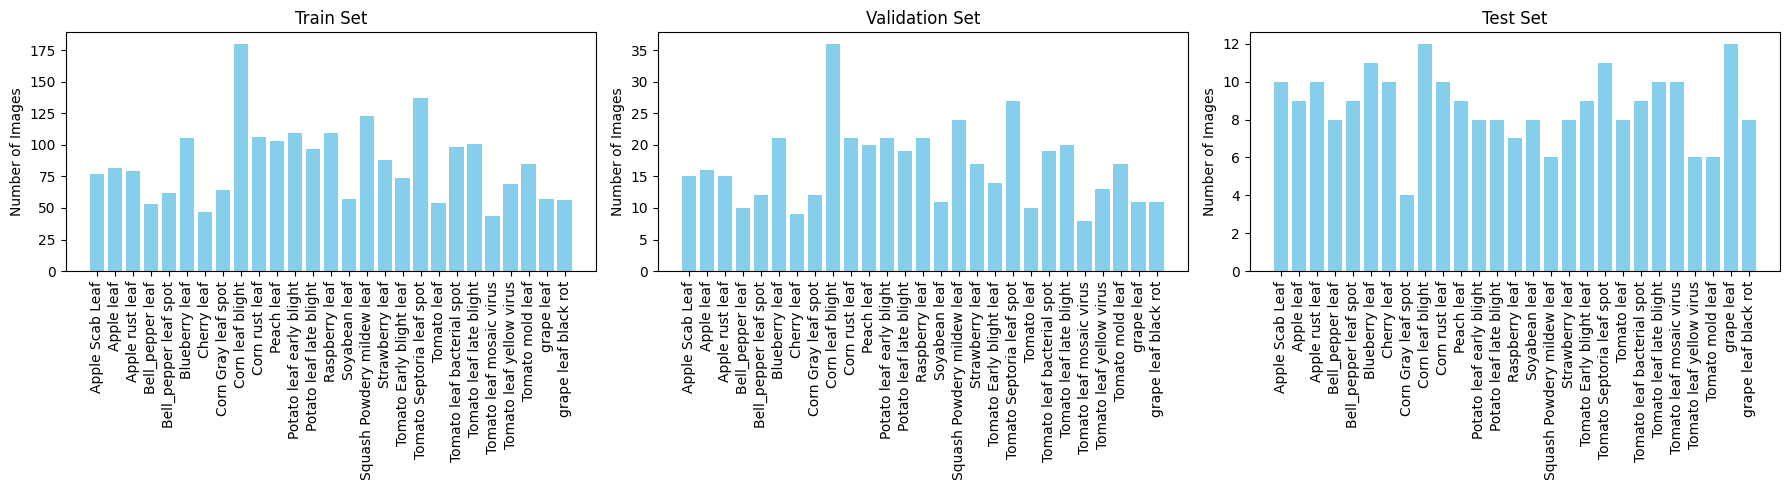

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Hàm đếm số lượng ảnh trong từng lớp
def count_images_per_class(generator):
    counter = Counter(generator.classes)
    class_counts = dict(counter)
    
    # Chuyển từ chỉ số lớp sang tên lớp
    class_names = {v: k for k, v in generator.class_indices.items()}
    class_counts_named = {class_names[k]: v for k, v in class_counts.items()}
    
    return class_counts_named

# Đếm ảnh trong từng tập
train_counts = count_images_per_class(train_generator)
valid_counts = count_images_per_class(val_generator)
test_counts = count_images_per_class(test_generator)

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, counts, title in zip(axes, [train_counts, valid_counts, test_counts], ['Train Set', 'Validation Set', 'Test Set']):
    ax.bar(counts.keys(), counts.values(), color='skyblue')
    ax.set_title(title)
    ax.set_xticklabels(counts.keys(), rotation=90)
    ax.set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


## Resnet

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2


# Initialize ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the first layers (unfreeze the last 30 layers)
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),  # Dropout to reduce overfitting
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()

In [10]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)


# Train Again with Fine-Tuning
with tf.device('GPU:0'):
    history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping,reduce_lr],
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.0612 - loss: 4.2542 - val_accuracy: 0.0444 - val_loss: 4.2288 - learning_rate: 1.0000e-05
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 869ms/step - accuracy: 0.2052 - loss: 3.7029 - val_accuracy: 0.0467 - val_loss: 4.3440 - learning_rate: 1.0000e-05
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 68s 850ms/step - accuracy: 0.2913 - loss: 3.3714 - val_accuracy: 0.0689 - val_loss: 4.3341 - learning_rate: 1.0000e-05
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 874ms/step - accuracy: 0.4254 - loss: 2.9811 - val_accuracy: 0.0667 - val_loss: 4.3459 - learning_rate: 1.0000e-05
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 843ms/step - accuracy: 0.4365 - loss: 2.7736 - val_accuracy: 0.0800 - val_loss: 4.2629 - learning_rate: 5.0000e-06
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 68s 847ms/step - accuracy: 0.5253 - loss: 2.5810 - val_accuracy: 0.0844 - val_loss: 4.2058 - learning_rate: 5.0000e-06
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 846ms/step - accuracy: 0.5342

In [11]:
model.save("Resnet_modifided_huy.h5")

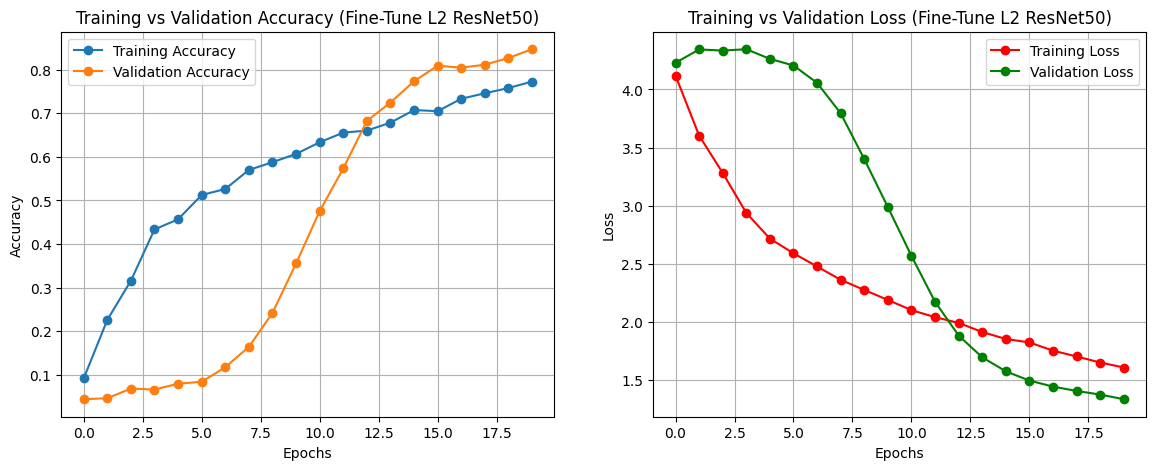

In [12]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axes[0].plot(history_finetune.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Fine-Tune L2 ResNet50)")
axes[0].legend()
axes[0].grid()

# Plot Loss
axes[1].plot(history_finetune.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(history_finetune.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Fine-Tune L2 ResNet50)")
axes[1].legend()
axes[1].grid()

# Save the plot
plt.savefig("/kaggle/working/fine_tune_L2_resnet50.png", dpi=300)
plt.show()



In [13]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 788ms/step - accuracy: 0.5497 - loss: 2.3702
Test Loss: 2.3250
Test Accuracy: 56.78%


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 743ms/step


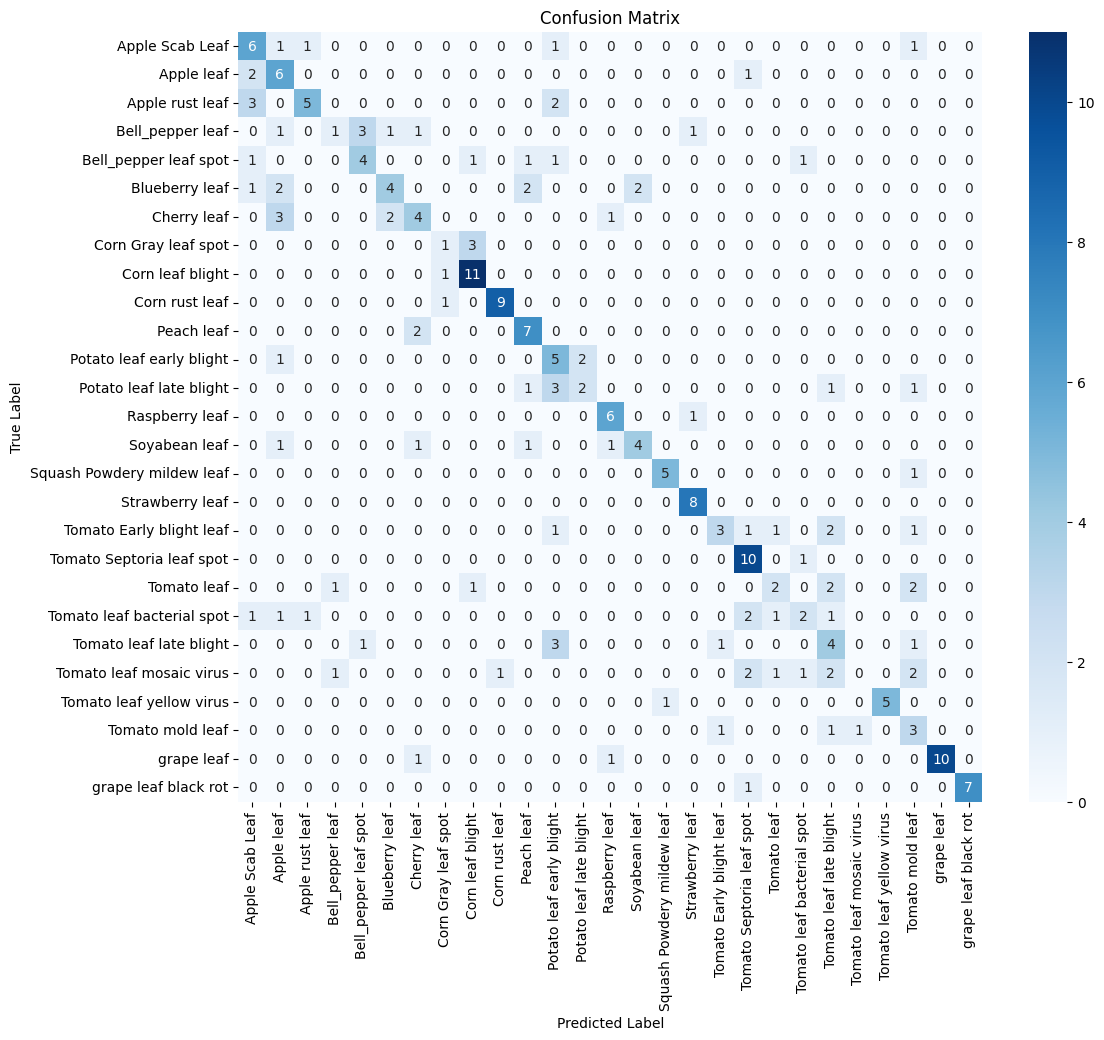

Classification Report:
                            precision    recall  f1-score   support

           Apple Scab Leaf       0.43      0.60      0.50        10
                Apple leaf       0.38      0.67      0.48         9
           Apple rust leaf       0.71      0.50      0.59        10
          Bell_pepper leaf       0.33      0.12      0.18         8
     Bell_pepper leaf spot       0.50      0.44      0.47         9
            Blueberry leaf       0.57      0.36      0.44        11
               Cherry leaf       0.44      0.40      0.42        10
       Corn Gray leaf spot       0.33      0.25      0.29         4
          Corn leaf blight       0.69      0.92      0.79        12
            Corn rust leaf       0.90      0.90      0.90        10
                Peach leaf       0.58      0.78      0.67         9
  Potato leaf early blight       0.31      0.62      0.42         8
   Potato leaf late blight       0.50      0.25      0.33         8
            Raspberry le

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Dự đoán nhãn trên tập kiểm tra
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Tạo Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## MobileNetV2

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# Initialize MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the first layers (unfreeze the last 30 layers)
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),  # Dropout to reduce overfitting
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


<ipython-input-15-cb26319d3f42>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 8, 8, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 27)                  │          13,851 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,927,707 (11.17 MB)

 Trainable params: 2,893,595 (11.04 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)


# Train Again with Fine-Tuning
with tf.device('GPU:0'):
    history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping,reduce_lr],
    verbose=1
    )

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.0596 - loss: 4.0958 - val_accuracy: 0.1333 - val_loss: 3.9038 - learning_rate: 1.0000e-05
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 66s 823ms/step - accuracy: 0.1417 - loss: 3.8506 - val_accuracy: 0.1822 - val_loss: 3.7209 - learning_rate: 1.0000e-05
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 64s 805ms/step - accuracy: 0.2019 - loss: 3.6642 - val_accuracy: 0.2422 - val_loss: 3.5464 - learning_rate: 1.0000e-05
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 811ms/step - accuracy: 0.2572 - loss: 3.4949 - val_accuracy: 0.2778 - val_loss: 3.3707 - learning_rate: 1.0000e-05
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 65s 820ms/step - accuracy: 0.2994 - loss: 3.3265 - val_accuracy: 0.3244 - val_loss: 3.2063 - learning_rate: 1.0000e-05
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 64s 815ms/step - accuracy: 0.3474 - loss: 3.1290 - val_accuracy: 0.3556 - val_loss: 3.0568 - learning_rate: 1.0000e-05
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 66s 818ms/step - accur

In [18]:
model.save("MobileNetV2_modifided_huy.h5")

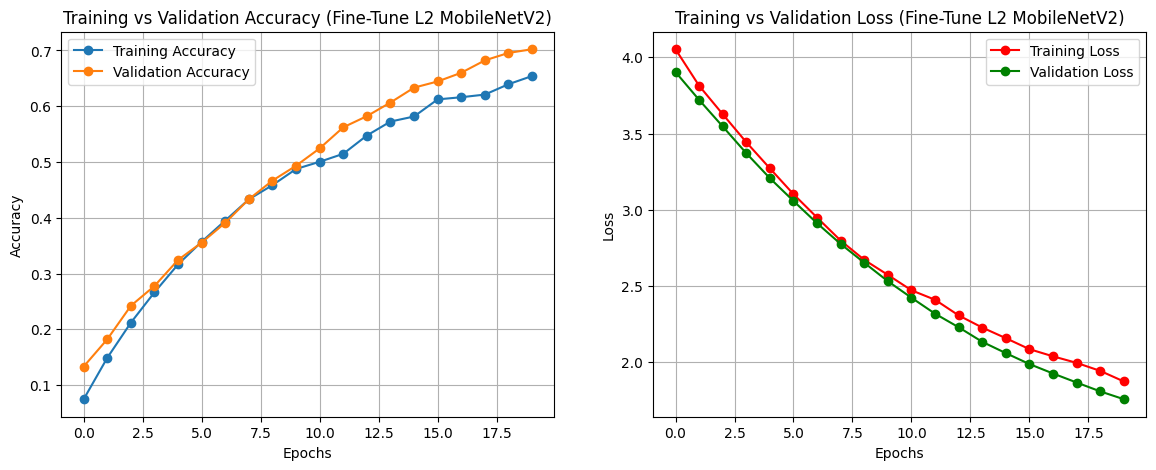

In [19]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axes[0].plot(history_finetune.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Fine-Tune L2 MobileNetV2)")
axes[0].legend()
axes[0].grid()

# Plot Loss
axes[1].plot(history_finetune.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(history_finetune.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Fine-Tune L2 MobileNetV2)")
axes[1].legend()
axes[1].grid()

# Save the plot
plt.savefig("/kaggle/working/fine_tune_L2_mobilenet.png", dpi=300)
plt.show()



In [20]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 578ms/step - accuracy: 0.5030 - loss: 2.3142
Test Loss: 2.2579
Test Accuracy: 49.58%


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 649ms/step


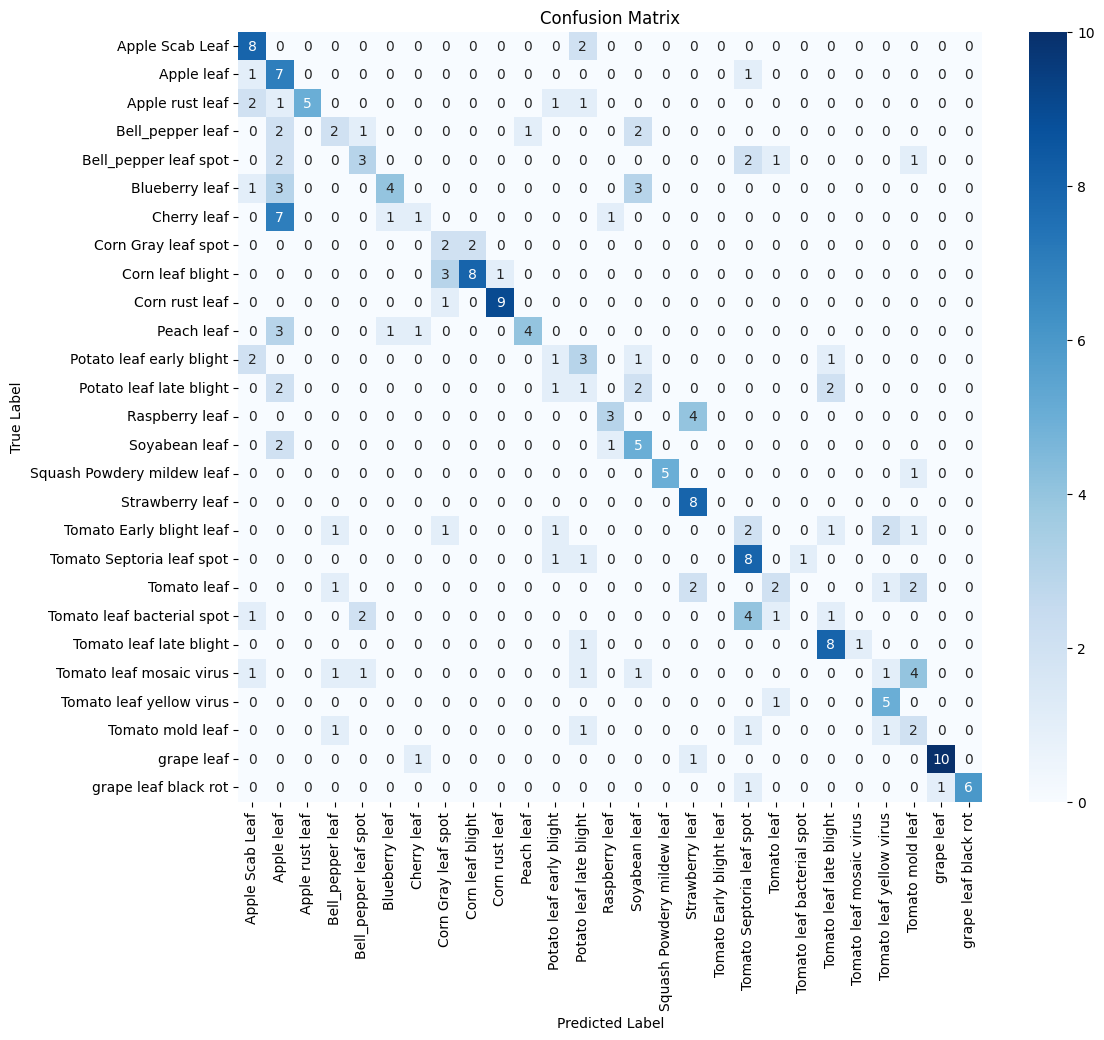

Classification Report:
                            precision    recall  f1-score   support

           Apple Scab Leaf       0.50      0.80      0.62        10
                Apple leaf       0.24      0.78      0.37         9
           Apple rust leaf       1.00      0.50      0.67        10
          Bell_pepper leaf       0.33      0.25      0.29         8
     Bell_pepper leaf spot       0.43      0.33      0.38         9
            Blueberry leaf       0.67      0.36      0.47        11
               Cherry leaf       0.33      0.10      0.15        10
       Corn Gray leaf spot       0.29      0.50      0.36         4
          Corn leaf blight       0.80      0.67      0.73        12
            Corn rust leaf       0.90      0.90      0.90        10
                Peach leaf       0.80      0.44      0.57         9
  Potato leaf early blight       0.20      0.12      0.15         8
   Potato leaf late blight       0.09      0.12      0.11         8
            Raspberry le

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Dự đoán nhãn trên tập kiểm tra
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Tạo Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## InceptionV3

In [11]:
batch_size = 32
target_size = (299, 299)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

# Load dataset with augmentation
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='training'
)

val_generator = val_datagen.flow_from_directory(  
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Do NOT shuffle for test evaluation
)


# Lấy số lớp
num_classes = train_generator.num_classes  
print(f"Number of classes: {num_classes}")

# Lấy danh sách tên lớp
class_names = list(train_generator.class_indices.keys())
print(f"Class names: {class_names}")


Found 2316 images belonging to 27 classes.
Found 450 images belonging to 27 classes.
Found 236 images belonging to 27 classes.
Number of classes: 27
Class names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


In [12]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# Initialize InceptionV3 as the base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the first layers (unfreeze the last 30 layers)
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),  # Dropout to reduce overfitting
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)


# Train Again with Fine-Tuning
with tf.device('GPU:0'):
    history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping,reduce_lr],
    verbose=1
    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.0560 - loss: 4.1464 - val_accuracy: 0.2133 - val_loss: 3.8121 - learning_rate: 1.0000e-05
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2227 - loss: 3.7672 - val_accuracy: 0.3578 - val_loss: 3.4850 - learning_rate: 1.0000e-05
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.3274 - loss: 3.4128 - val_accuracy: 0.4489 - val_loss: 3.1064 - learning_rate: 1.0000e-05
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4025 - loss: 3.0724 - val_accuracy: 0.5222 - val_loss: 2.7453 - learning_rate: 1.0000e-05
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4552 - loss: 2.7945 - val_accuracy: 0.6022 - val_loss: 2.4569 - learning_rate: 1.0000e-05
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5142 - loss: 2.5497 - val_accuracy: 0.6467 - val_loss: 2.2214 - learning_rate: 1.0000e-05
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5765 - loss: 2.3498 - 

In [14]:
model.save("InceptionV3_modifided_huy.h5")

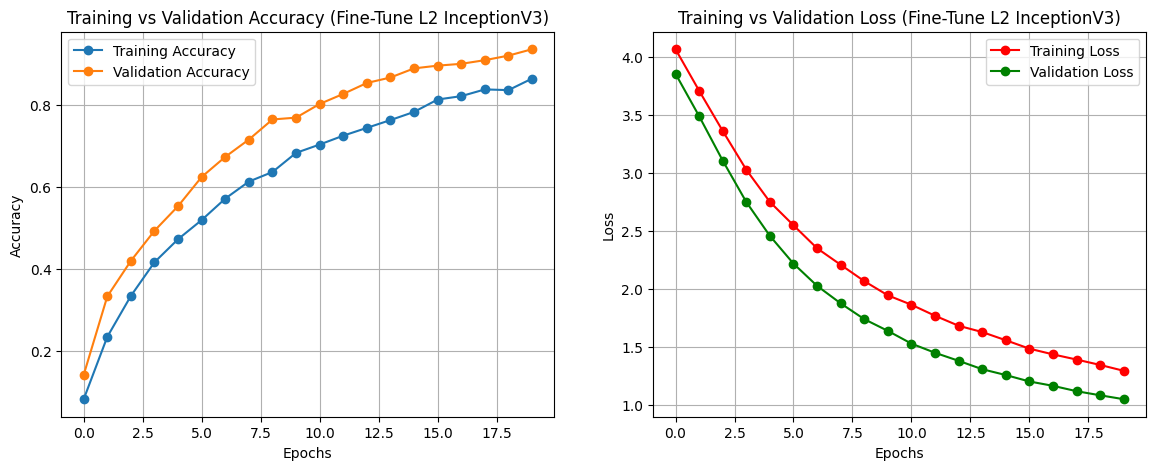

In [29]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axes[0].plot(history_finetune.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Fine-Tune L2 InceptionV3)")
axes[0].legend()
axes[0].grid()

# Plot Loss
axes[1].plot(history_finetune.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(history_finetune.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Fine-Tune L2 InceptionV3)")
axes[1].legend()
axes[1].grid()

# Save the plot
plt.savefig("/kaggle/working/fine_tune_L2_mobilenet.png", dpi=300)
plt.show()



In [30]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 960ms/step - accuracy: 0.5884 - loss: 1.9202
Test Loss: 1.9613
Test Accuracy: 58.90%


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step 


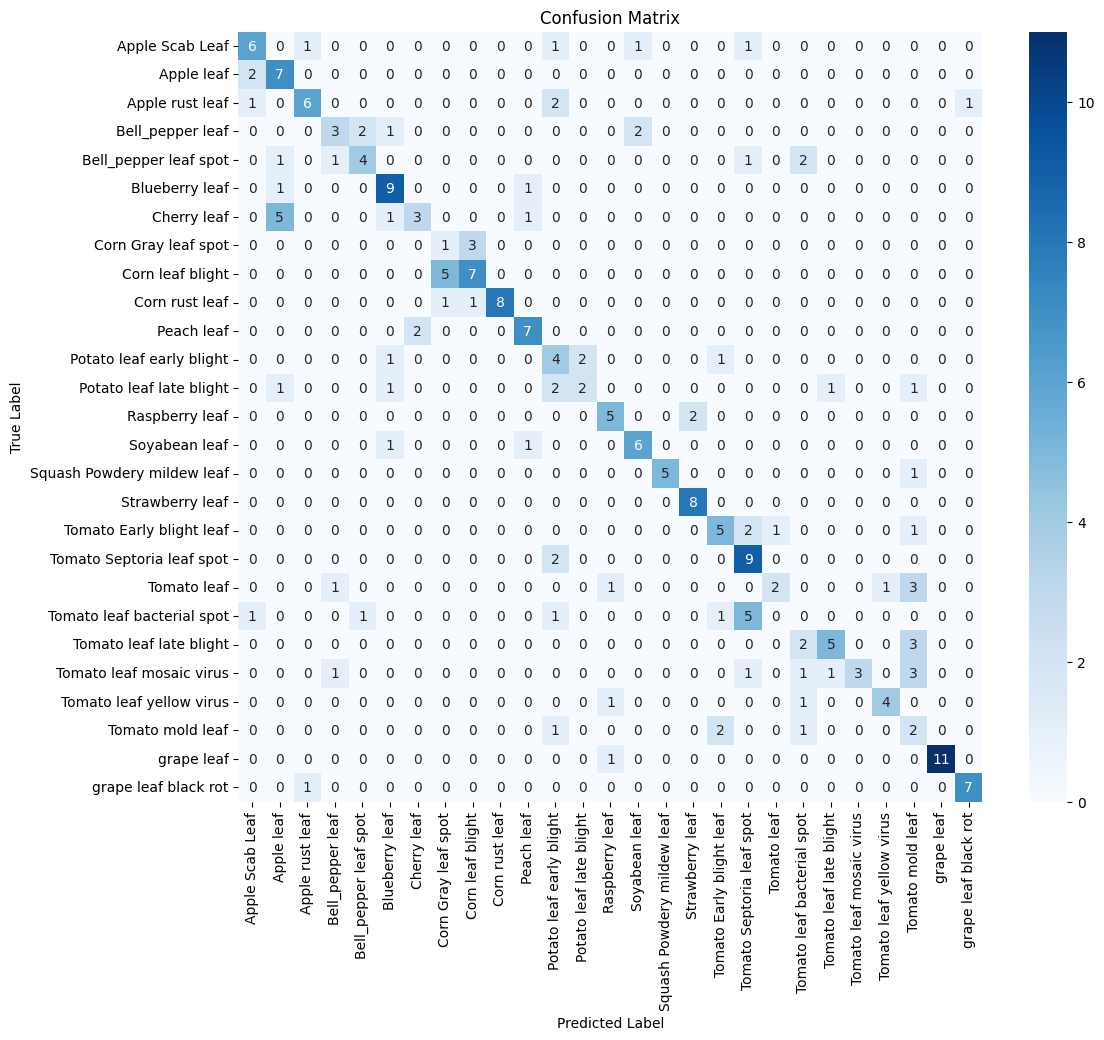

Classification Report:
                            precision    recall  f1-score   support

           Apple Scab Leaf       0.60      0.60      0.60        10
                Apple leaf       0.47      0.78      0.58         9
           Apple rust leaf       0.75      0.60      0.67        10
          Bell_pepper leaf       0.50      0.38      0.43         8
     Bell_pepper leaf spot       0.57      0.44      0.50         9
            Blueberry leaf       0.64      0.82      0.72        11
               Cherry leaf       0.60      0.30      0.40        10
       Corn Gray leaf spot       0.14      0.25      0.18         4
          Corn leaf blight       0.64      0.58      0.61        12
            Corn rust leaf       1.00      0.80      0.89        10
                Peach leaf       0.70      0.78      0.74         9
  Potato leaf early blight       0.31      0.50      0.38         8
   Potato leaf late blight       0.50      0.25      0.33         8
            Raspberry le

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Dự đoán nhãn trên tập kiểm tra
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Tạo Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## EfficientNet

In [4]:
batch_size = 32
target_size = (256, 256)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

# Load dataset with augmentation
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='training'
)

val_generator = val_datagen.flow_from_directory(  
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./255)  
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/plant-doc-dataset/PlantDoc-Dataset/test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # Do NOT shuffle for test evaluation
)


# Lấy số lớp
num_classes = train_generator.num_classes  
print(f"Number of classes: {num_classes}")

# Lấy danh sách tên lớp
class_names = list(train_generator.class_indices.keys())
print(f"Class names: {class_names}")


Found 2316 images belonging to 27 classes.
Found 450 images belonging to 27 classes.
Found 236 images belonging to 27 classes.
Number of classes: 27
Class names: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# Initialize EfficientNetB0 as the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Unfreeze the last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),  # Dropout to reduce overfitting
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)


# Train Again with Fine-Tuning
with tf.device('GPU:0'):
    history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping,reduce_lr],
    verbose=1
    )

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.0394 - loss: 4.0677 - val_accuracy: 0.0333 - val_loss: 4.0274 - learning_rate: 1.0000e-05
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 855ms/step - accuracy: 0.0697 - loss: 3.9714 - val_accuracy: 0.0267 - val_loss: 4.0235 - learning_rate: 1.0000e-05
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 834ms/step - accuracy: 0.1018 - loss: 3.9027 - val_accuracy: 0.0400 - val_loss: 4.0238 - learning_rate: 1.0000e-05
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 840ms/step - accuracy: 0.1613 - loss: 3.8055 - val_accuracy: 0.0511 - val_loss: 4.0280 - learning_rate: 1.0000e-05
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 68s 845ms/step - accuracy: 0.2104 - loss: 3.7182 - val_accuracy: 0.0422 - val_loss: 4.0181 - learning_rate: 1.0000e-05
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 76s 962ms/step - accuracy: 0.2725 - loss: 3.6148 - val_accuracy: 0.0556 - val_loss: 4.0165 - learning_rate: 1.0000e-05
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 69s 855ms/step - accuracy: 0.2917

In [7]:
model.save("EfficientNetB0_modifided.h5")

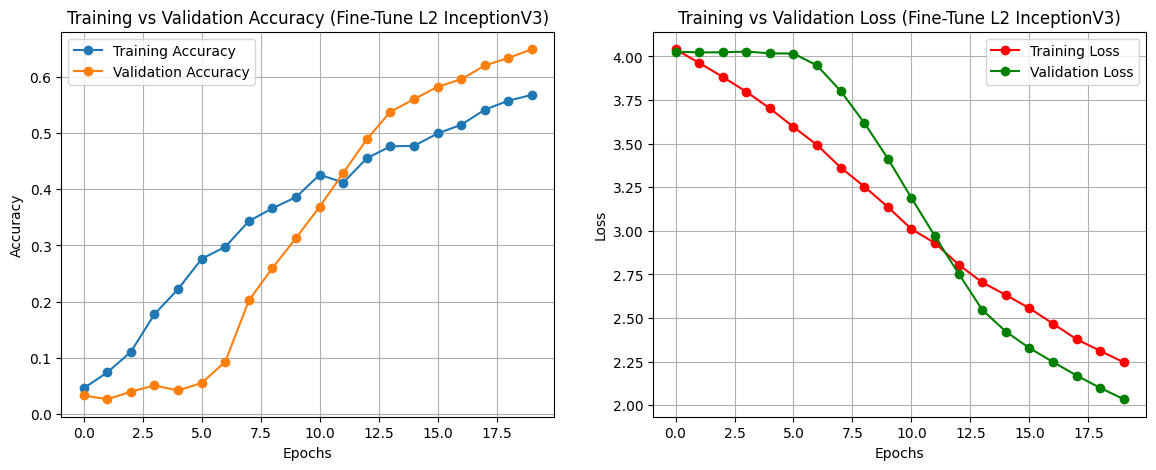

In [8]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axes[0].plot(history_finetune.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', marker='o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Training vs Validation Accuracy (Fine-Tune L2 InceptionV3)")
axes[0].legend()
axes[0].grid()

# Plot Loss
axes[1].plot(history_finetune.history['loss'], label='Training Loss', marker='o', color='r')
axes[1].plot(history_finetune.history['val_loss'], label='Validation Loss', marker='o', color='g')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training vs Validation Loss (Fine-Tune L2 InceptionV3)")
axes[1].legend()
axes[1].grid()

# Save the plot
plt.savefig("/kaggle/working/fine_tune_L2_mobilenet.png", dpi=300)
plt.show()



In [9]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4932 - loss: 2.4142  
Test Loss: 2.3952
Test Accuracy: 49.15%


8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 


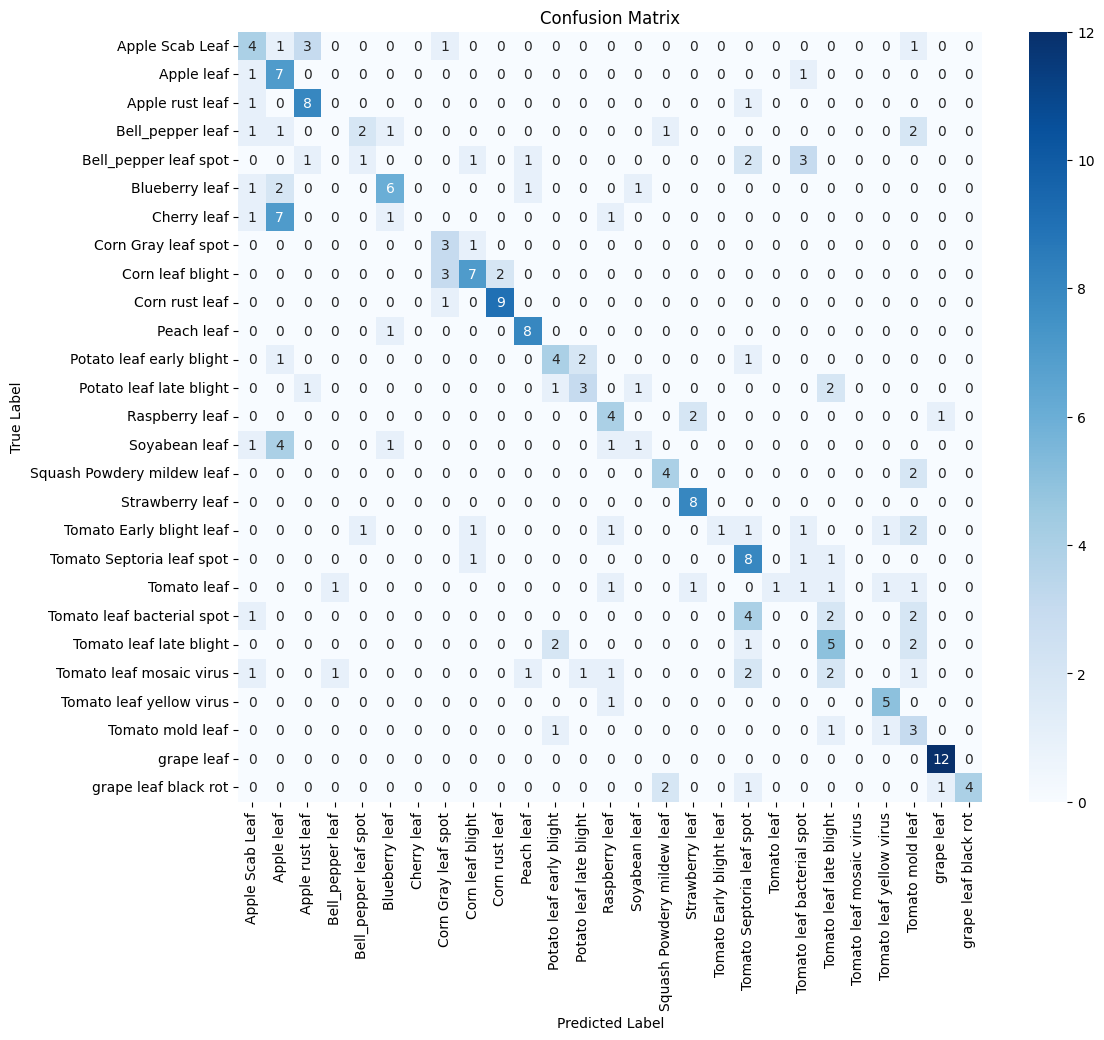

Classification Report:
                            precision    recall  f1-score   support

           Apple Scab Leaf       0.33      0.40      0.36        10
                Apple leaf       0.30      0.78      0.44         9
           Apple rust leaf       0.62      0.80      0.70        10
          Bell_pepper leaf       0.00      0.00      0.00         8
     Bell_pepper leaf spot       0.25      0.11      0.15         9
            Blueberry leaf       0.60      0.55      0.57        11
               Cherry leaf       0.00      0.00      0.00        10
       Corn Gray leaf spot       0.38      0.75      0.50         4
          Corn leaf blight       0.64      0.58      0.61        12
            Corn rust leaf       0.82      0.90      0.86        10
                Peach leaf       0.73      0.89      0.80         9
  Potato leaf early blight       0.50      0.50      0.50         8
   Potato leaf late blight       0.50      0.38      0.43         8
            Raspberry le

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Dự đoán nhãn trên tập kiểm tra
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

# Tạo Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# In báo cáo phân loại
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
